## 🔒 LABOR MARKET TIGHTNESS

**Indicators:**

| Indicator                  | Source              | Notes                                                             |
| -------------------------- | ------------------- | ----------------------------------------------------------------- |
| Job Openings Rate          | JOLTS (`JTSJOL`)    | Total Nonfarm or by industry                                      |
| Hires Rate                 | JOLTS (`JTSHIR`)    | Hiring flow                                                       |
| Beveridge Ratio            | Derived             | = Job Openings / Unemployed                                       |
| Openings per Hire          | Derived             | = Job Openings / Hires                                            |
| **Prime-Age LFPR (25–54)** | BLS (`LNS11300060`) | Best signal of active labor force engagement, avoids demographics |

**Feature Engineering Ideas:**

* `OpeningsPerUnemployed = Job Openings / Unemployed`
* `OpeningsPerHire = Job Openings / Hires`
* `PrimeLFPR_Zscore = z-score(LNS11300060)`
* `ParticipationGap = Pre-pandemic Prime LFPR – Current Prime LFPR`
* Normalize tightness indicators using z-scores or rolling trends


In [156]:
import pandas as pd

LMT_df= pd.read_excel('Data/Labor_Market_Tightness.xlsx')

# FEATURE ENGINEERING

## Calculate the Openings_Per_Unemployed
LMT_df["Openings_Per_Unemployed"]= LMT_df['Job_Openings_Rate']/LMT_df['Unemployment_Level']

## Calculate the Openings_Per_Hire
LMT_df["Openings_Per_Hire"]= LMT_df['Job_Openings_Rate']/LMT_df['Hires_Rate']

## Calculate the PrimeLFPR Z-Score
LMT_df["PrimeLFPR_Zscore"]= (LMT_df['Prime_Age_Labor_Force_Participation_Rate'] - LMT_df['Prime_Age_Labor_Force_Participation_Rate'].mean()) / LMT_df['Prime_Age_Labor_Force_Participation_Rate'].std()

## Calculate the ParticipationGap

baseline = LMT_df[(LMT_df['observation_date'] >= '2015-01-01') & (LMT_df['observation_date'] <= '2019-12-01')]['Prime_Age_Labor_Force_Participation_Rate'].mean()

LMT_df['ParticipationGap'] = baseline - LMT_df['Prime_Age_Labor_Force_Participation_Rate']


## 😣 LABOR MARKET DISTRESS

**Indicators:**

| Indicator                 | Source              | Notes                                        |
| ------------------------- | ------------------- | -------------------------------------------- |
| Unemployment Rate (U-3)   | BLS (`UNRATE`)      | Official unemployment rate                   |
| **U-6 Unemployment Rate** | BLS (`U6RATE`)      | Includes underemployed & discouraged workers |
| Initial Jobless Claims    | FRED (`ICSA`)       | Weekly job loss inflow                       |
| Continued Jobless Claims  | FRED (`CCSA`)       | Persistent unemployment inflow               |
| Median Weeks Unemployed   | BLS (`LNS13008275`) | Duration signal of unemployment hardship     |
| Long-term Unemployed (%)  | Derived             | = UEMP27OV / UNEMPLOY                        |

**Feature Engineering Ideas:**

* `Unemployed27Share = UEMP27OV / UNEMPLOY`
* `Lagged_Claims = Rolling average of ICSA over 4–8 weeks`
* `MedianWeeks_Zscore`
* `U6_U3_Spread = U6RATE - UNRATE` (hidden slack signal)
* Combine into a `DistressIndex` using PCA or averaging

In [139]:
import pandas as pd

LMD_df= pd.read_excel('Data/Labor_Market_Distress.xlsx')

# FEATURE ENGINEERING

## Calculate the Long-Term Unemployed (%)
LMD_df["%_Long_Term_Unemployed"]= LMD_df['Unemployed_27_Weeks_More']/LMD_df['Unemployment_Level']

## Calculate the Lagged_Claims (Rolling average of ICSA over 4-8 Weeks)
Lagged_Claims_4m = LMD_df['Initial_Jobless_Claims'].rolling(window=4).mean()
Lagged_Claims_8m = LMD_df['Initial_Jobless_Claims'].rolling(window=8).mean()

LMD_df['Lagged_Claims_Average'] = (Lagged_Claims_4m + Lagged_Claims_8m) / 2

## Calculate Median Weeks Z-Score
LMD_df["MedianWeeks_Zscore"]= (LMD_df['Median_Weeks_Unemployed'] - LMD_df['Median_Weeks_Unemployed'].mean()) / LMD_df['Median_Weeks_Unemployed'].std()

## Calculate U6_U3_Spread (hidden slack signal)
LMD_df["U6_U3_Spread"]=  LMD_df['%_U6_Unemployment_Rate'] - LMD_df['%_U3_Unemployment_Rate']

LMD_df

,observation_date,%_U3_Unemployment_Rate,%_U6_Unemployment_Rate,Initial_Jobless_Claims,Continued_Jobless_Claims,Median_Weeks_Unemployed,Unemployment_Level,Unemployed_27_Weeks_More,%_Long_Term_Unemployed,Lagged_Claims_Average,MedianWeeks_Zscore,U6_U3_Spread
0,2000-12-01,3.9,6.9,346000,2306400,6.0,5634,642,0.113951,NaN,-1.326004,3.0
1,2001-01-01,4.2,7.3,340000,2395750,5.8,6023,676,0.112236,NaN,-1.370951,3.1
2,2001-02-01,4.2,7.3,371250,2486500,6.1,6089,714,0.117261,NaN,-1.303531,3.1
3,2001-03-01,4.3,7.3,387200,2585400,6.6,6141,696,0.113337,NaN,-1.191164,3.0
4,2001-04-01,4.4,7.4,396750,2697250,5.9,6271,712,0.113539,NaN,-1.348478,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01,4.1,7.5,222250,1860750,10.4,6886,1551,0.225240,227100.00,-0.337177,3.4
289,2025-01-01,4.0,7.5,213500,1865250,10.4,6849,1443,0.210688,225131.25,-0.337177,3.5
290,2025-02-01,4.1,8.0,226000,1859750,10.0,7052,1455,0.206324,223250.00,-0.427070,3.9
291,2025-03-01,4.2,7.9,223200,1863200,9.8,7083,1495,0.211069,222893.75,-0.472017,3.7


## 🔁 LABOR MOBILITY / CONFIDENCE

**Indicators:**

| Indicator              | Source           | Notes                                                                           |
| ---------------------- | ---------------- | ------------------------------------------------------------------------------- |
| Quit Rate              | JOLTS (`JTSQUR`) | Lower values suggest fear of switching jobs                                     |
| Quits-to-Layoffs Ratio | Derived          | = Quits / Layoffs; higher ratio means confidence in job switching               |
| Layoffs and Discharges | JOLTS (`JTSLDL`) | Involuntary exits — higher values may signal a weakening labor market           |
| **Total Separations**  | JOLTS (`JTSTSL`) | Total worker exits (voluntary + involuntary); helps contextualize flow dynamics |

**Feature Engineering Ideas:**

* `QuitsToLayoffs = Quits / Layoffs`
* `VoluntaryShare = Quits / Total Separations` (confidence indicator)
* `LayoffShock = % change in Layoffs MoM`
* `SeparationFlow_z = z-score(Total Separations)` (to detect surges or freezes)
* Normalize metrics using rolling z-scores or trend slopes

In [140]:
import pandas as pd

LCM_df = pd.read_excel('Data/Labor_Confidence_and_Mobility.xlsx')

# FEATURE ENGINEERING

## Calculate the Quits-to-Layoff_Ratio
LCM_df['Quits_to_Layoffs']= LCM_df['Quits_Rate']/LCM_df['Layoffs_and_Discharges']

## Calculate the Voluntary-to-Quit_Ratio
LCM_df['Voluntary_to_Quits']= LCM_df['Quits_Rate']/LCM_df['Total_Seperations']

## Calculate the LayoffShock
LCM_df['LayoffShock']= LCM_df['Layoffs_and_Discharges'].pct_change() * 100

## Calculate Seperation Flow Z-Score
LCM_df["SeperationFlow_Zscore"]= (LCM_df['Total_Seperations'] - LCM_df['Total_Seperations'].mean()) / LCM_df['Total_Seperations'].std()


LCM_df

,observation_date,Quits_Rate,Layoffs_and_Discharges,Total_Seperations,Quits_to_Layoffs,Voluntary_to_Quits,LayoffShock,SeperationFlow_Zscore
0,2000-12-01,2882,2018,5240,1.428147,0.550000,NaN,0.155752
1,2001-01-01,3245,2220,5842,1.461712,0.555460,10.009911,0.802299
2,2001-02-01,3053,1855,5231,1.645822,0.583636,-16.441441,0.146086
3,2001-03-01,3054,2133,5566,1.431786,0.548688,14.986523,0.505875
4,2001-04-01,3163,1883,5414,1.679766,0.584226,-11.720581,0.342627
...,...,...,...,...,...,...,...,...
287,2024-11-01,3032,1739,5087,1.743531,0.596029,-2.740492,-0.008570
288,2024-12-01,3095,1669,5082,1.854404,0.609012,-4.025302,-0.013940
289,2025-01-01,3256,1674,5272,1.945042,0.617602,0.299581,0.190120
290,2025-02-01,3250,1780,5316,1.825843,0.611362,6.332139,0.237376


## 💸 COMPENSATION & PARTICIPATION SIGNALS

**Indicators:**

| Indicator                                | Source                          | Notes                                                             |
| ---------------------------------------- | ------------------------------- | ----------------------------------------------------------------- |
| Avg Weekly Earnings – Total Private      | CES (`CES0500000030`)           | Nominal wages for majority of workforce                           |
| Median Hourly Wage Growth – 3MMA         | FRB ATL (`FRBATLWGT3MMAUMHWGO`) | Real-time, outlier-resistant wage pressure indicator              |
| Prime-Age Employment-to-Population Ratio | BLS (`LNS12300060`)             | Measures active employment engagement for 25–54 y/o               |
| Prime-Age Labor Force Participation Rate | BLS (`LNS11300060`)             | Best signal of core labor market participation                    |
| CPI Inflation (YoY % Change)             | FRED (`CPIAUCSL`)               | Used to deflate wages for purchasing power                        |
| Avg Weekly Hours – Total Private         | CES (`AWHAETP`)                 | Gauges workload; leading indicator for hours-based hiring freezes |

**Feature Engineering Ideas:**

* `AWE_YoY = AWE.pct_change(periods=12) * 100`
* `RealWageGrowth = AWE_YoY - CPI_YoY`
* `WageGrowth_YoY = AWE_YoY`
* `MedianWage3MMA_Z = z-score(FRBATL_Wage3MMA)`
* `PrimeAgeEPOP_Zscore`
* `PrimeLFPR_Trend = Current – 12-month lag`
* `WeeklyHours_Trend = Δ AWHAETP over 12 months`
* Include wage and hour trends in a `CompensationPressureIndex`

In [141]:
CPS_df = pd.read_excel('Data/Compensation_and_Participation_Signal.xlsx')
# FEATURE ENGINEERING

## Calculate Average_Weekly_Earning Year-to-Year
CPS_df['AWE_YoY'] = CPS_df['Average_Weekly_Earnings'].pct_change(periods=12) * 100

## Calculate RealWageGrowth
CPI_YoY = CPS_df['Consumer_Price_Index'].pct_change(periods=12) * 100
CPS_df['RealWageGrowth'] = CPS_df['AWE_YoY'] - CPI_YoY

## Calculate PrimeAgeEPOP Z-score
CPS_df["PrimeAgeEPOP_z"]= (CPS_df['Prime_Age_Employment_to_Population_Ratio'] - CPS_df['Prime_Age_Employment_to_Population_Ratio'].mean()) / CPS_df['Prime_Age_Employment_to_Population_Ratio'].std()

## Calculate MedianWage3MMA Z-score
CPS_df["MedianWage3MMA_z"]= (CPS_df['Median_Hourly_Wage_Growth_3MMA'] - CPS_df['Median_Hourly_Wage_Growth_3MMA'].mean()) / CPS_df['Median_Hourly_Wage_Growth_3MMA'].std()


## Calculate PrimeLFPR_Trend
CPS_df["PrimeLFPR_Trend"]= CPS_df['Prime_Age_Labor_Force_Participation_Rate'] - CPS_df['Prime_Age_Labor_Force_Participation_Rate'].shift(12)


## Calculate WeeklyHours_Trend
CPS_df['WeeklyHours_Trend'] = CPS_df['Average_Weekly_Hours'] - CPS_df['Average_Weekly_Hours'].shift(12)

CPS_df

,observation_date,Average_Weekly_Earnings,Prime_Age_Employment_to_Population_Ratio,Consumer_Price_Index,Prime_Age_Labor_Force_Participation_Rate,Average_Weekly_Hours,Median_Hourly_Wage_Growth_3MMA,AWE_YoY,RealWageGrowth,PrimeAgeEPOP_z,MedianWage3MMA_z,PrimeLFPR_Trend,WeeklyHours_Trend
0,2000-12-01,485.86,81.4,174.600,-0.11905,NaN,5.4,NaN,NaN,1.557256,1.594719,NaN,NaN
1,2001-01-01,488.72,81.4,175.600,-0.35545,NaN,5.4,NaN,NaN,1.557256,1.594719,NaN,NaN
2,2001-02-01,488.24,81.3,176.000,-0.35545,NaN,5.3,NaN,NaN,1.507319,1.505035,NaN,NaN
3,2001-03-01,491.72,81.3,176.100,-0.23725,NaN,5.3,NaN,NaN,1.507319,1.505035,NaN,NaN
4,2001-04-01,490.96,80.9,176.400,-0.82938,NaN,5.3,NaN,NaN,1.307570,1.505035,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01,1033.58,80.5,317.603,0.24038,34.2,4.2,3.729351,0.856985,1.107821,0.518513,-0.48601,-0.2
289,2025-01-01,1034.88,80.7,319.086,0.24010,34.1,4.1,4.328891,1.329478,1.207696,0.428829,-0.36376,-0.1
290,2025-02-01,1038.58,80.5,319.775,0.00000,34.2,4.3,3.870464,1.056194,1.107821,0.608197,-0.60241,-0.1
291,2025-03-01,1046.45,80.4,319.615,-0.11990,34.3,4.3,3.892816,1.487231,1.057884,0.608197,-0.48091,-0.1


In [142]:
import pandas as pd
import sqlite3


# Set up in-memory SQLite connection
conn = sqlite3.connect(':memory:')

# Load data into SQL tables
CPS_df.to_sql('CPS', conn, index=False, if_exists='replace')
LCM_df.to_sql('LCM', conn, index=False, if_exists='replace')
LMD_df.to_sql('LMD', conn, index=False, if_exists='replace')
LMT_df.to_sql('LMT', conn, index=False, if_exists='replace')



# SQL query to join all lagging indicator tables on observation_date
sql_query = """
SELECT *
FROM CPS
LEFT JOIN LCM ON CPS.observation_date = LCM.observation_date
LEFT JOIN LMD ON CPS.observation_date = LMD.observation_date
LEFT JOIN LMT ON CPS.observation_date = LMT.observation_date

"""

# Execute query and load result into DataFrame
Full_Dataset_df = pd.read_sql_query(sql_query, conn)

# Save to CSV

# Close the database connection
conn.close()

# Display the final joined DataFrame
Full_Dataset_df

,observation_date,Average_Weekly_Earnings,Prime_Age_Employment_to_Population_Ratio,Consumer_Price_Index,Prime_Age_Labor_Force_Participation_Rate,Average_Weekly_Hours,Median_Hourly_Wage_Growth_3MMA,AWE_YoY,RealWageGrowth,PrimeAgeEPOP_z,...,U6_U3_Spread,observation_date,Job_Openings_Rate,Hires_Rate,Prime_Age_Labor_Force_Participation_Rate,Unemployment_Level,Openings_Per_Unemployed,Openings_Per_Hire,PrimeLFPR_Zscore,ParticipationGap
0,2000-12-01 00:00:00,485.86,81.4,174.600,-0.11905,NaN,5.4,NaN,NaN,1.557256,...,3.0,2000-12-01 00:00:00,5088.0,5426.0,-0.11905,5634,0.903088,0.937707,-0.144961,0.507885
1,2001-01-01 00:00:00,488.72,81.4,175.600,-0.35545,NaN,5.4,NaN,NaN,1.557256,...,3.1,2001-01-01 00:00:00,5234.0,5722.0,-0.35545,6023,0.869002,0.914715,-0.488144,0.744285
2,2001-02-01 00:00:00,488.24,81.3,176.000,-0.35545,NaN,5.3,NaN,NaN,1.507319,...,3.1,2001-02-01 00:00:00,5097.0,5303.0,-0.35545,6089,0.837083,0.961154,-0.488144,0.744285
3,2001-03-01 00:00:00,491.72,81.3,176.100,-0.23725,NaN,5.3,NaN,NaN,1.507319,...,3.0,2001-03-01 00:00:00,4762.0,5528.0,-0.23725,6141,0.775444,0.861433,-0.316553,0.626085
4,2001-04-01 00:00:00,490.96,80.9,176.400,-0.82938,NaN,5.3,NaN,NaN,1.307570,...,3.0,2001-04-01 00:00:00,4615.0,5204.0,-0.82938,6271,0.735927,0.886818,-1.176151,1.218215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01 00:00:00,1033.58,80.5,317.603,0.24038,34.2,4.2,3.729351,0.856985,1.107821,...,3.4,2024-12-01 00:00:00,7508.0,5374.0,0.24038,6886,1.090328,1.397097,0.376825,0.148455
289,2025-01-01 00:00:00,1034.88,80.7,319.086,0.24010,34.1,4.1,4.328891,1.329478,1.207696,...,3.5,2025-01-01 00:00:00,7762.0,5371.0,0.24010,6849,1.133304,1.445168,0.376418,0.148735
290,2025-02-01 00:00:00,1038.58,80.5,319.775,0.00000,34.2,4.3,3.870464,1.056194,1.107821,...,3.9,2025-02-01 00:00:00,7480.0,5370.0,0.00000,7052,1.060692,1.392924,0.027864,0.388835
291,2025-03-01 00:00:00,1046.45,80.4,319.615,-0.11990,34.3,4.3,3.892816,1.487231,1.057884,...,3.7,2025-03-01 00:00:00,7192.0,5411.0,-0.11990,7083,1.015389,1.329144,-0.146195,0.508735


## 🧊 COMPOSITE INDEX FEATURE ENGINEERING (Frozen Index)

To build the **Frozen Job Market Index**, follow this workflow:

### 1. **Standardize (Z-score)** the following variables:

| Direction        | Variable                                 |
| ---------------- | ---------------------------------------- |
| ⬆️ = More Frozen | Median Weeks Unemployed                  |
| ⬆️ = More Frozen | Unemployment Rate (U-3)                  |
| ⬆️ = More Frozen | Initial Jobless Claims                   |
| ⬆️ = More Frozen | U6–U3 Spread                             |
| ⬇️ = More Frozen | Beveridge Ratio / OpeningsPerUnemployed  |
| ⬇️ = More Frozen | Quit Rate                                |
| ⬇️ = More Frozen | Quits-to-Layoffs Ratio                   |
| ⬇️ = More Frozen | Prime-Age Labor Force Participation Rate |
| ⬇️ = More Frozen | Prime-Age Employment-to-Population Ratio |
| ⬇️ = More Frozen | Real Wage Growth                         |
| ⬇️ = More Frozen | Avg Weekly Hours – Total Private         |
| ⬇️ = More Frozen | Median Hourly Wage Growth – 3MMA         |

---

In [143]:
import pandas as pd
import sqlite3


# Set up in-memory SQLite connection
conn = sqlite3.connect(':memory:')

# Load data into SQL tables
CPS_df.to_sql('CPS', conn, index=False, if_exists='replace')
LCM_df.to_sql('LCM', conn, index=False, if_exists='replace')
LMD_df.to_sql('LMD', conn, index=False, if_exists='replace')
LMT_df.to_sql('LMT', conn, index=False, if_exists='replace')



# SQL query to join all lagging indicator tables on observation_date
sql_query = """
SELECT 
  CPS.observation_date, 
  Median_Weeks_Unemployed, 
  "%_U3_Unemployment_Rate", 
  Initial_Jobless_Claims, 
  U6_U3_Spread, 
  Openings_Per_Unemployed, 
  Quits_Rate, 
  Quits_to_Layoffs, 
  CPS.Prime_Age_Labor_Force_Participation_Rate, 
  Prime_Age_Employment_to_Population_Ratio, 
  RealWageGrowth,
  Average_Weekly_Hours,
  Median_Hourly_Wage_Growth_3MMA
FROM CPS
LEFT JOIN LCM ON CPS.observation_date = LCM.observation_date
LEFT JOIN LMD ON CPS.observation_date = LMD.observation_date
LEFT JOIN LMT ON CPS.observation_date = LMT.observation_date

"""

# Execute query and load result into DataFrame
Full_Dataset_df = pd.read_sql_query(sql_query, conn)

# Save to CSV

# Close the database connection
conn.close()

# Display the final joined DataFrame
Full_Dataset_df


,observation_date,Median_Weeks_Unemployed,%_U3_Unemployment_Rate,Initial_Jobless_Claims,U6_U3_Spread,Openings_Per_Unemployed,Quits_Rate,Quits_to_Layoffs,Prime_Age_Labor_Force_Participation_Rate,Prime_Age_Employment_to_Population_Ratio,RealWageGrowth,Average_Weekly_Hours,Median_Hourly_Wage_Growth_3MMA
0,2000-12-01 00:00:00,6.0,3.9,346000,3.0,0.903088,2882.0,1.428147,-0.11905,81.4,NaN,NaN,5.4
1,2001-01-01 00:00:00,5.8,4.2,340000,3.1,0.869002,3245.0,1.461712,-0.35545,81.4,NaN,NaN,5.4
2,2001-02-01 00:00:00,6.1,4.2,371250,3.1,0.837083,3053.0,1.645822,-0.35545,81.3,NaN,NaN,5.3
3,2001-03-01 00:00:00,6.6,4.3,387200,3.0,0.775444,3054.0,1.431786,-0.23725,81.3,NaN,NaN,5.3
4,2001-04-01 00:00:00,5.9,4.4,396750,3.0,0.735927,3163.0,1.679766,-0.82938,80.9,NaN,NaN,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01 00:00:00,10.4,4.1,222250,3.4,1.090328,3095.0,1.854404,0.24038,80.5,0.856985,34.2,4.2
289,2025-01-01 00:00:00,10.4,4.0,213500,3.5,1.133304,3256.0,1.945042,0.24010,80.7,1.329478,34.1,4.1
290,2025-02-01 00:00:00,10.0,4.1,226000,3.9,1.060692,3250.0,1.825843,0.00000,80.5,1.056194,34.2,4.3
291,2025-03-01 00:00:00,9.8,4.2,223200,3.7,1.015389,3332.0,2.138639,-0.11990,80.4,1.487231,34.3,4.3


In [144]:
from scipy.stats import zscore

# Z-scores for ↑ = more frozen (keep direction as-is)
Full_Dataset_df['MedianWeeks_z']     = zscore(Full_Dataset_df['Median_Weeks_Unemployed'], nan_policy='omit')
Full_Dataset_df['U3Rate_z']          = zscore(Full_Dataset_df['%_U3_Unemployment_Rate'], nan_policy='omit')
Full_Dataset_df['InitialClaims_z']   = zscore(Full_Dataset_df['Initial_Jobless_Claims'], nan_policy='omit')
Full_Dataset_df['U6_U3_Spread_z']    = zscore(Full_Dataset_df['U6_U3_Spread'], nan_policy='omit')

# Z-scores for ↓ = more frozen (reverse the direction by multiplying by -1)
Full_Dataset_df['OpeningsPerUnemp_z'] = -1 * zscore(Full_Dataset_df['Openings_Per_Unemployed'], nan_policy='omit')
Full_Dataset_df['QuitRate_z']         = -1 * zscore(Full_Dataset_df['Quits_Rate'], nan_policy='omit')
Full_Dataset_df['QuitsToLayoffs_z']   = -1 * zscore(Full_Dataset_df['Quits_to_Layoffs'], nan_policy='omit')
Full_Dataset_df['PrimeLFPR_z']        = -1 * zscore(Full_Dataset_df['Prime_Age_Labor_Force_Participation_Rate'], nan_policy='omit')
Full_Dataset_df['PrimeEPOP_z']        = -1 * zscore(Full_Dataset_df['Prime_Age_Employment_to_Population_Ratio'], nan_policy='omit')
Full_Dataset_df['RealWageGrowth_z']   = -1 * zscore(Full_Dataset_df['RealWageGrowth'], nan_policy='omit')
Full_Dataset_df['AverageWeeklyHours_z']   = -1 * zscore(Full_Dataset_df['Average_Weekly_Hours'], nan_policy='omit')
Full_Dataset_df['MedianWage3MMA_z']   = -1 * zscore(Full_Dataset_df['Median_Hourly_Wage_Growth_3MMA'], nan_policy='omit')

Full_Dataset_df

,observation_date,Median_Weeks_Unemployed,%_U3_Unemployment_Rate,Initial_Jobless_Claims,U6_U3_Spread,Openings_Per_Unemployed,Quits_Rate,Quits_to_Layoffs,Prime_Age_Labor_Force_Participation_Rate,Prime_Age_Employment_to_Population_Ratio,...,InitialClaims_z,U6_U3_Spread_z,OpeningsPerUnemp_z,QuitRate_z,QuitsToLayoffs_z,PrimeLFPR_z,PrimeEPOP_z,RealWageGrowth_z,AverageWeeklyHours_z,MedianWage3MMA_z
0,2000-12-01 00:00:00,6.0,3.9,346000,3.0,0.903088,2882.0,1.428147,-0.11905,81.4,...,-0.096893,-1.234417,-0.435073,-0.067524,0.275584,0.145209,-1.559920,NaN,NaN,-1.597447
1,2001-01-01 00:00:00,5.8,4.2,340000,3.1,0.869002,3245.0,1.461712,-0.35545,81.4,...,-0.114947,-1.160103,-0.357686,-0.633049,0.213140,0.488980,-1.559920,NaN,NaN,-1.597447
2,2001-02-01 00:00:00,6.1,4.2,371250,3.1,0.837083,3053.0,1.645822,-0.35545,81.3,...,-0.020917,-1.160103,-0.285220,-0.333928,-0.129372,0.488980,-1.509898,NaN,NaN,-1.507610
3,2001-03-01 00:00:00,6.6,4.3,387200,3.0,0.775444,3054.0,1.431786,-0.23725,81.3,...,0.027075,-1.234417,-0.145278,-0.335486,0.268813,0.317095,-1.509898,NaN,NaN,-1.507610
4,2001-04-01 00:00:00,5.9,4.4,396750,3.0,0.735927,3163.0,1.679766,-0.82938,80.9,...,0.055811,-1.234417,-0.055562,-0.505299,-0.192520,1.178163,-1.309807,NaN,NaN,-1.507610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2024-12-01 00:00:00,10.4,4.1,222250,3.4,1.090328,3095.0,1.854404,0.24038,80.5,...,-0.469250,-0.937162,-0.860170,-0.399361,-0.517409,-0.377470,-1.109717,-0.112854,0.916490,-0.519400
289,2025-01-01 00:00:00,10.4,4.0,213500,3.5,1.133304,3256.0,1.945042,0.24010,80.7,...,-0.495578,-0.862849,-0.957740,-0.650186,-0.686029,-0.377062,-1.209762,-0.403609,1.388062,-0.429563
290,2025-02-01 00:00:00,10.0,4.1,226000,3.9,1.060692,3250.0,1.825843,0.00000,80.5,...,-0.457966,-0.565595,-0.792886,-0.640838,-0.464275,-0.027912,-1.109717,-0.235440,0.916490,-0.609238
291,2025-03-01 00:00:00,9.8,4.2,223200,3.7,1.015389,3332.0,2.138639,-0.11990,80.4,...,-0.466391,-0.714222,-0.690033,-0.768588,-1.046190,0.146445,-1.059694,-0.500684,0.444918,-0.609238


<Axes: >

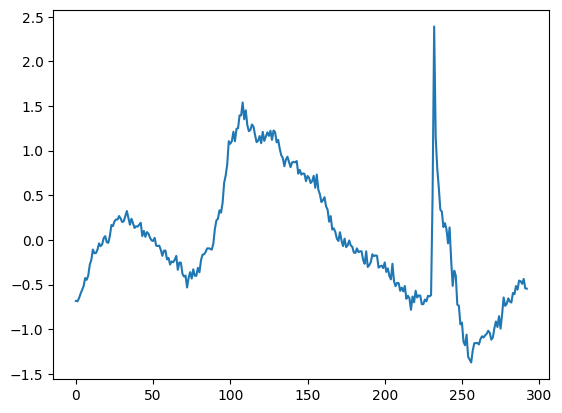

In [145]:
z_cols = [col for col in Full_Dataset_df.columns if col.endswith('_z')]
Full_Dataset_df['Frozen_Index'] = Full_Dataset_df[z_cols].mean(axis=1)
Full_Dataset_df['Frozen_Index'].plot()

#### ✅ Step 1: Weight Based Composite scores



In [146]:
# Identify z-score columns
z_cols = [col for col in Full_Dataset_df.columns if col.endswith('_z')]

# Create the Frozen Index (Simple Average)
Full_Dataset_df['Frozen_Index'] = Full_Dataset_df[z_cols].mean(axis=1, skipna=True)


#### ✅ Step 3: Optional Enhancements


##### **A.** 3–6 Month Rolling Average



In [147]:
Full_Dataset_df['Frozen_Index_Smoothed'] = Full_Dataset_df['Frozen_Index'].rolling(window=3).mean()

##### **B.** Normalize to 0–1 Range

In [148]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Full_Dataset_df['Frozen_Index_Scaled'] = scaler.fit_transform(
    Full_Dataset_df[['Frozen_Index']].fillna(method='ffill')
)


In [149]:
def classify_frozen_tier(score):
    if score <= -0.5:
        return 'Loose'
    elif -0.5 < score <= 0.2:
        return 'Balanced'
    elif 0.2 < score <= 0.8:
        return 'Mild Freeze'
    else:
        return 'Severe Freeze'

Full_Dataset_df['Frozen_Tier'] = Full_Dataset_df['Frozen_Index'].apply(classify_frozen_tier)


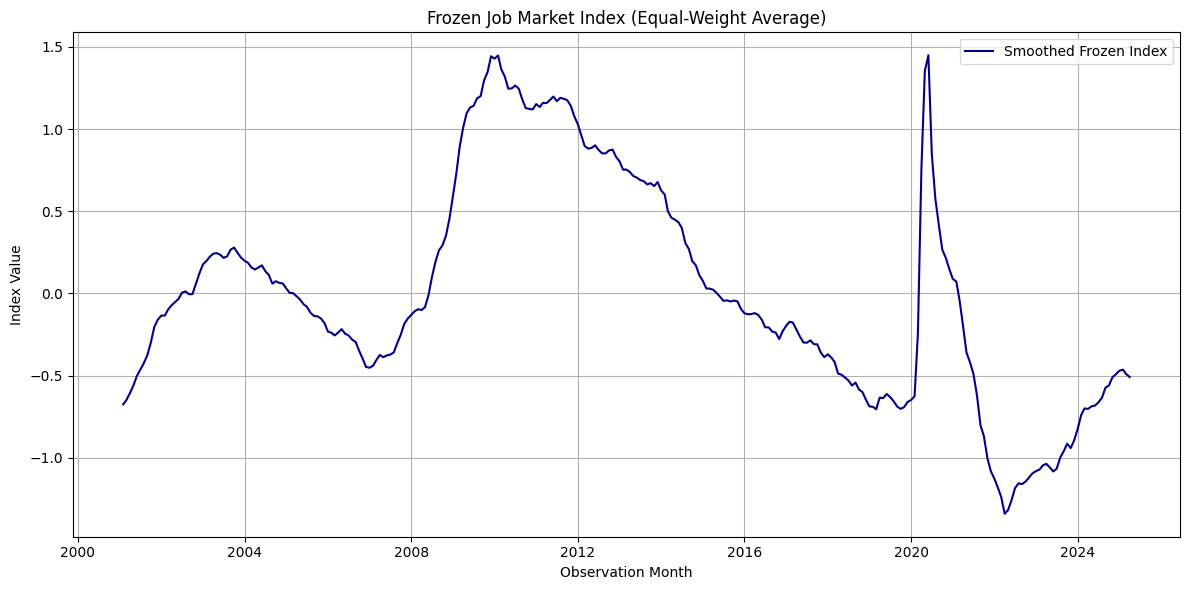

In [150]:
import matplotlib.pyplot as plt

# Ensure the observation_date column is parsed as datetime and sorted
Full_Dataset_df['observation_date'] = pd.to_datetime(Full_Dataset_df['observation_date'])
Full_Dataset_df = Full_Dataset_df.sort_values('observation_date')

# Plot the smoothed Frozen Index against observation dates
plt.figure(figsize=(12, 6))
plt.plot(Full_Dataset_df['observation_date'], Full_Dataset_df['Frozen_Index_Smoothed'], label='Smoothed Frozen Index', color='darkblue')
plt.title('Frozen Job Market Index (Equal-Weight Average)')
plt.xlabel('Observation Month')
plt.ylabel('Index Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Thanks — this chart shows your **Frozen Job Market Index (Equal-Weight Average)** from around 2001 to 2024. Here's a full breakdown of what it means:

---

## 📊 **Interpretation: Frozen Job Market Index (2001–2024)**

This index combines multiple labor indicators to reflect **how “frozen” or disrupted** the job market is — with **higher values indicating worse freeze conditions**.

---

### 📈 **Contextual Breakdown by Period:**

| **Period**       | **Index Behavior**                  | **Interpretation**                                                              |
| ---------------- | ----------------------------------- | ------------------------------------------------------------------------------- |
| **2001–2003**    | 🔺 Moderate increase                | Post–dot-com recession and 9/11: job market stress built up                     |
| **2004–2007**    | 🔻 Decline                          | Labor market gradually unfroze, economic expansion restored hiring conditions   |
| **2008–2009**    | 🚨 Steep rise to peak               | **Great Recession**: severe freeze, mass layoffs, long-term unemployment spikes |
| **2010–2019**    | ⬇️ Long steady decline              | Recovery decade: hiring improves, job market loosens, conditions normalize      |
| **2020 (COVID)** | 🚀 **Sharp spike** to all-time high | Sudden, historic freeze from pandemic shutdowns and record job losses           |
| **2021–2022**    | ⬇️ Rapid fall                       | Recovery & stimulus-driven thaw: employers rehire, confidence returns           |
| **2023–2024**    | 🔺 Gradual rebound                  | Signs of **refreezing**: distress and slack rising again post-peak recovery     |

---

### 🧠 Key Insights:

* Your index **perfectly captures major labor market shocks** (2008, 2020) with dramatic spikes.
* The **2020 spike** is especially steep — reflecting how sudden and synchronized COVID’s labor shock was.
* The **2023–2024 upturn** suggests the market may be **tightening for employers but cooling for workers**, possibly indicating a soft freeze or stagnation.

---

### 🧭 Final Takeaway:

The **Frozen Index** provides a reliable macro signal of how difficult or disrupted the job market is at any time — with today's value pointing to **mild-to-moderate freeze conditions** following the post-pandemic rebound.

## **Create Supplementary Indices**

Build separate indices to capture other dimensions of the labor market that the Frozen Index doesn’t fully explain.

**Examples:**


| **Index**                          | **What It Measures**                             | **🔺 Increase Means**                                | **🔻 Decrease Means**                            |
| ---------------------------------- | ------------------------------------------------ | ---------------------------------------------------- | ------------------------------------------------ |
| **Labor Market Distress Index**    | How tough and unstable the job market feels      | More people are struggling to find or keep jobs      | The job market is getting healthier              |
| **Labor Market Tightness Index**   | How hard it is for companies to hire workers     | Fewer workers available, harder to fill jobs         | Easier to hire, more workers looking for jobs    |
| **Compensation Pressure Index**    | How much pressure there is to raise pay or hours | Companies feel pushed to pay more or give more hours | Less pressure to raise pay, job demand is softer |
| **Mobility & Voluntariness Index** | How confident people are to leave their jobs     | Workers feel safe quitting and finding new jobs      | People are holding onto jobs out of caution      |



### 1. **Labor Market Distress Index**

Focus: unemployment, joblessness duration, and claims
**Suggested indicators:**

| Variable                   | Why It Matters                                  |
| -------------------------- | ----------------------------------------------- |
| `Unemployment Rate (U-3)`  | Core unemployment benchmark                     |
| `U6 Unemployment Rate`     | Captures discouraged and underemployed workers  |
| `Initial Jobless Claims`   | Real-time layoffs trend                         |
| `Continued Jobless Claims` | Ongoing unemployment burden                     |
| `Median Weeks Unemployed`  | Duration/hardship of unemployment               |
| `Long-term Unemployed (%)` | Persistent unemployment signal                  |
| `U6_U3_Spread`             | Hidden slack and labor underutilization measure |


<Axes: >

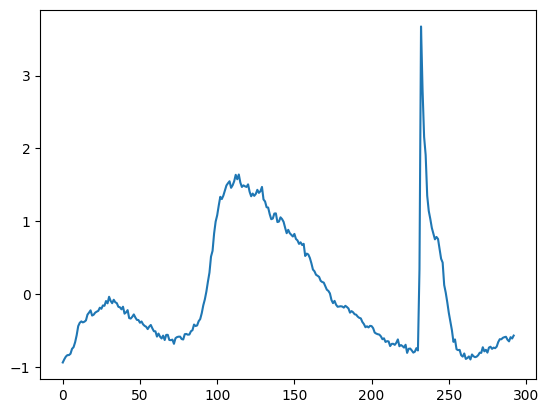

In [151]:
distress_vars = [
    '%_U3_Unemployment_Rate',
    '%_U6_Unemployment_Rate',
    'Initial_Jobless_Claims',
    'Continued_Jobless_Claims',
    'Median_Weeks_Unemployed',
    '%_Long_Term_Unemployed',
    'U6_U3_Spread'
]

for col in distress_vars:
    LMD_df[col + '_z'] = zscore(LMD_df[col], nan_policy='omit')

LMD_df['Distress_Index'] = LMD_df[[col + '_z' for col in distress_vars]].mean(axis=1, skipna=True)

LMD_df['Distress_Index'].plot()

| **Period**        | **Distress Trend**      | **What It Likely Reflects**                       |
| ----------------- | ----------------------- | ------------------------------------------------- |
| 2008–2010         | 🔺 Sharp increase       | Mass layoffs, long-term joblessness               |
| 2011–2019         | 🔻 Slow, steady decline | Economic expansion and steady hiring              |
| 2020              | 🚨 Vertical spike       | COVID shock — record job losses                   |
| 2021–early 2023   | 🔻 Rapid normalization  | Stimulus, recovery, labor rebound                 |
| **Mid 2023–2024** | 🔺 **Creeping upward**  | Layoff activity rising, unemployment sticky again |


### 2. **Labor Market Tightness Index**

Focus: unemployment, joblessness duration, and claims
**Suggested indicators:**

| Variable                    | Direction    | Why It's Included                            |
| --------------------------- | ------------ | -------------------------------------------- |
| `Job_Openings_Rate`         | ⬆️ = Tighter | More open jobs signal strong employer demand |
| `Hires_Rate`                | ⬆️ = Tighter | High hiring means active labor turnover      |
| `OpeningsPerUnemployed`     | ⬆️ = Tighter | More jobs per unemployed = tighter market    |
| `OpeningsPerHire`           | ⬆️ = Tighter | Harder to fill jobs implies high tightness   |
| `PrimeLFPR` (`LNS11300060`) | ⬆️ = Tighter | More prime-age workers are active            |


<Axes: >

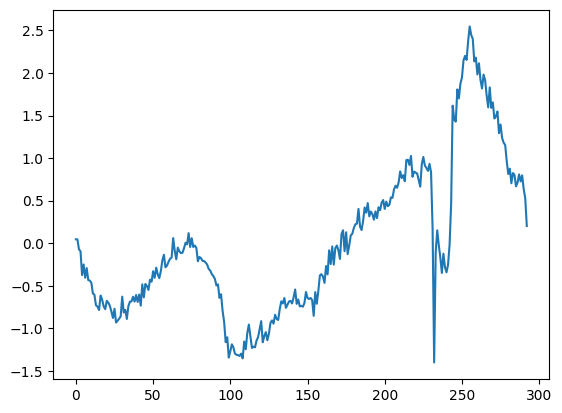

In [152]:
from scipy.stats import zscore

tightness_vars = [
    'Job_Openings_Rate',
    'Hires_Rate',
    'Openings_Per_Unemployed',
    'Openings_Per_Hire',
    'Prime_Age_Labor_Force_Participation_Rate'  # Prime-Age Labor Force Participation Rate
]

# Calculate z-scores
for col in tightness_vars:
    LMT_df[col + '_z'] = zscore(LMT_df[col], nan_policy='omit')

# Combine into index
LMT_df['TightnessIndex'] = LMT_df[[col + '_z' for col in tightness_vars]].mean(axis=1, skipna=True)

LMT_df['TightnessIndex'].plot()

| **Period**       | **Tightness Trend**  | **What It Likely Reflects**                              |
| ---------------- | -------------------- | -------------------------------------------------------- |
| **2001–2003**    | 🔻 Declining         | Post-dot-com and 9/11 recession; looser labor conditions |
| **2004–2007**    | 🔼 Gradual rise      | Economic expansion; tighter job market for employers     |
| **2008–2009**    | ⏬ Sharp drop         | Great Recession; mass layoffs, job surplus               |
| **2010–2015**    | ⏸️ Flat & low        | Slow recovery; hiring resumes but slack remains          |
| **2016–2019**    | 🔼 Steady increase   | Tighter conditions; low unemployment, rising demand      |
| **2020 (COVID)** | ⏬ Sudden collapse    | Shock event; hiring freezes, participation crash         |
| **2021–2022**    | 🚀 Rapid surge       | Reopening boom, record job openings, labor shortages     |
| **2023–2024**    | 🔻 Gradual softening | Market cooling, hiring stabilizing, more available labor |


### 2. **Wage & Participation Index**

Focus: earnings power, labor force engagement
**Suggested indicators:**

| Variable             | Reason for Inclusion                                      |
| -------------------- | --------------------------------------------------------- |
| `AHE: CES0500000030` | Baseline for paychecks – weekly nominal earnings          |
| `WageGrowth_YoY`     | Speed of earnings change over past year                   |
| `RealWageGrowth`     | Wage growth adjusted for inflation                        |
| `MedianWage3MMA`     | Real-time median hourly wage growth (Fed Atlanta)         |
| `WeeklyHours_Trend`  | Are workers working more hours? → signals labor intensity |
| `Prime-Age LFPR`     | Measures willingness/ability to participate in labor      |
| `Prime-Age EPOP`     | Measures actual employment of core-age workers            |


<Axes: >

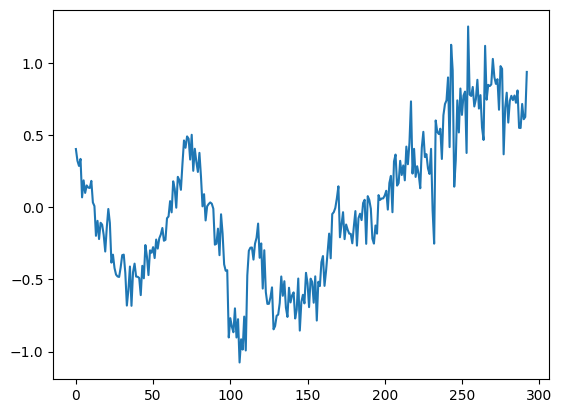

In [153]:
compensation_vars= [
    'Average_Weekly_Earnings',
    'RealWageGrowth',
    'Prime_Age_Labor_Force_Participation_Rate',
    'Prime_Age_Employment_to_Population_Ratio',
    'AWE_YoY',
    'Median_Hourly_Wage_Growth_3MMA',
    'WeeklyHours_Trend'
]

for col in compensation_vars:
    CPS_df[col + '_z'] = zscore(CPS_df[col], nan_policy='omit')

CPS_df['CompensationPressureIndex'] = CPS_df[[col + '_z' for col in compensation_vars]].mean(axis=1, skipna=True)

CPS_df['CompensationPressureIndex'].plot()

| **Period**   | **Pressure Trend**        | **What It Suggests**                                           |
| ------------ | ------------------------- | -------------------------------------------------------------- |
| 2001–2003    | 🔻 Falling                | Low wage growth, weak job market                               |
| 2004–2007    | 🔼 Rising                 | Growing employer pressure to raise pay/hours                   |
| 2008–2010    | 📉 Drops sharply          | Recession cuts demand; no need for wage increases              |
| 2011–2016    | ⏸️ Flat and soft          | Recovery too slow for real compensation pressure               |
| 2017–2019    | 🔼 Building again         | Labor tightening, wage growth trends up                        |
| 2020 (COVID) | 📉 Temporary dip          | Short disruption, but stimulus blunted downward pressure       |
| 2021–2024    | 🔺 Strong, sustained rise | Employers consistently under pressure to increase compensation |


### 3. **Mobility & Voluntariness Index**

Focus: how confident workers are to move jobs
**Suggested indicators:**

| Variable                 | Direction          | Why It Matters                                      |
| ------------------------ | ------------------ | --------------------------------------------------- |
| `Quit_Rate`              | ⬆️ = More Mobility | Direct signal of job-switching confidence           |
| `Quits_to_Layoffs`       | ⬆️ = More Mobility | Workers leaving voluntarily vs. being pushed out    |
| `Layoffs_and_Discharges` | ⬇️ = More Mobility | Inverse signal: more layoffs = lower mobility       |
| `Voluntary_to_Quits`     | ⬆️ = More Mobility | Quits / Total Separations → direct confidence proxy |


🧠 *Note: invert Layoffs — higher layoffs = less voluntary mobility*

<Axes: >

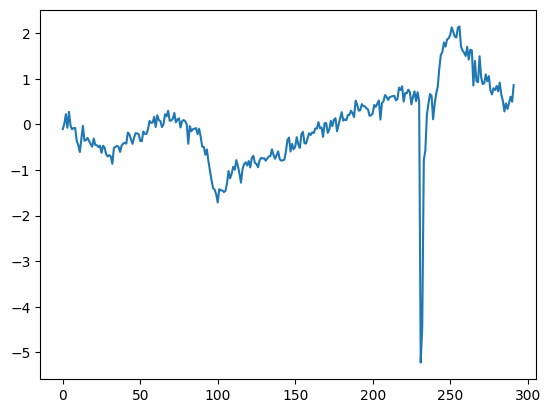

In [ ]:
mobility_vars = [
    'Quits_Rate',
    'Quits_to_Layoffs',
    'Layoffs_and_Discharges',
    'Voluntary_to_Quits'
]

for col in mobility_vars:
    if col in ['Layoffs_and_Discharges']:  # Invert this one
        LCM_df[col + '_z'] = -1 * zscore(LCM_df[col], nan_policy='omit')
    else:
        LCM_df[col + '_z'] = zscore(LCM_df[col], nan_policy='omit')

LCM_df['MobilityIndex'] = LCM_df[[col + '_z' for col in mobility_vars]].mean(axis=1, skipna=True)
LCM_df['MobilityIndex'].plot()


| **Period**   | **Mobility Trend**           | **What It Suggests**                                        |
| ------------ | ---------------------------- | ----------------------------------------------------------- |
| 2001–2003    | 🔻 Weak, cautious            | Workers hesitant to leave jobs                              |
| 2004–2007    | 🔼 Slow return of confidence | Job switching starts to recover                             |
| 2008–2010    | 📉 Severe drop               | Layoffs surge, quits collapse during recession              |
| 2011–2019    | 📈 Consistent rise           | Strong economy gives workers more flexibility               |
| 2020 (COVID) | ⏬ Historic crash             | Unprecedented job market freeze                             |
| 2021–2022    | 🚀 Confidence surges         | Great Resignation, record quit rates                        |
| 2023–2024    | 🔻 Cooling off slightly      | Still mobile, but some workers holding jobs more cautiously |
